In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from ram.analysis.run_manager import RunManager
from ram.analysis.model_selection.combo_search import CombinationSearch
from ram.analysis.model_selection.pair_search import PairSearch
from ram.analysis.statistics import get_stats, rollup_returns

In [2]:
RunManager.get_run_names('StatArbStrategy')

,RunName,RunDate,Completed,Description
0,run_0068,2018-03-06,True,"Sector 20, version 002"
1,run_0069,2018-03-07,True,"Sector 20, version 2 rerun with univ filtering"
2,run_0070,2018-03-19,True,"Sector 20, post refactor run"
3,run_0071,2018-03-21,True,"Sector 20, 2001 start date, 16cpu comp"
4,run_0072,2018-03-21,True,"Sector 20, 2001 start date, 64cpu comp"
5,run_0078,2018-04-18,True,"Sector 20, new pricing data"
6,run_0079,2018-04-25,True,Rerun with data since 2004
7,run_0080,2018-04-26,False,Rerun of version 24 data
8,run_0081,2018-04-30,True,New hyperparams
9,run_0085,2018-05-01,True,"new params, longer params/hyperparms"


In [4]:
drop_params = [('model', "{u'type': u'reg'}"), ('per_side_count', 5), ('score_var', 'prma_20')]
run1 = RunManager('StatArbStrategy', 'run_0090', test_periods=5, drop_params=drop_params)
run2 = RunManager('StatArbStrategy', 'run_0092', test_periods=5)

In [5]:
comb1 = CombinationSearch()
comb1.add_run(run1)
comb1.params['training_epochs'] = 10
comb1.set_selection_criteria('sharpe')
comb1.start()

Reading and aggregating runs...


  0%|          | 0/10 [00:00<?, ?it/s]

Finished aggregating runs...


100%|██████████| 10/10 [02:19<00:00, 13.78s/it]


In [6]:
pairs = PairSearch()
pairs.params['training_periods'] = 0
pairs.add_run(run1)
pairs.start()

  0%|          | 0/10 [00:00<?, ?it/s]

Reading and aggregating runs...
Finished aggregating runs...


100%|██████████| 10/10 [24:11<00:00, 146.87s/it]


In [9]:
pairs2 = PairSearch()
pairs2.params['training_periods'] = 0
pairs2.params['training_epochs'] = 1
pairs2.add_run(run2)
pairs2.start()


  0%|          | 0/1 [00:00<?, ?it/s]

Reading and aggregating runs...
Finished aggregating runs...




100%|██████████| 1/1 [36:23<00:00, 2183.66s/it]


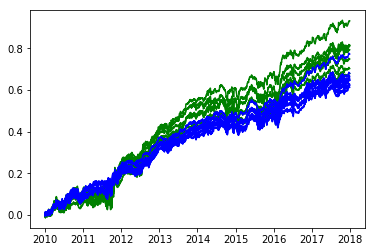

In [22]:
inds = comb1.best_results_returns.dropna().index

plt.figure()
plt.plot(pairs.best_results_returns.loc[inds].cumsum(), 'g')
plt.plot(comb1.best_results_returns.loc[inds].cumsum(), 'b')
plt.show()

In [36]:
df1 = rollup_returns(comb1.best_results_returns, 7)
df1['yr'] = df1.sum(axis=1)
df1

Qtr,1,2,3,4,yr
Year,,,,,
2009,NaN,NaN,NaN,NaN,NaN
2010,0.044918,-0.007494,0.068775,-0.004585,0.101615
2011,0.030504,0.025651,-0.013733,0.091716,0.134138
2012,0.020846,0.006190,0.036244,0.071297,0.134576
2013,-0.019419,0.037126,0.044774,0.011956,0.074437
2014,0.019314,0.025895,-0.023944,0.022001,0.043266
2015,-0.001885,0.051811,-0.027247,0.041245,0.063925
2016,0.057403,0.015782,0.017566,0.043561,0.134312
2017,0.032230,0.035731,0.003695,0.015721,0.087377


In [32]:
rollup_returns?

In [52]:
x = comb1.best_results_returns
y = pairs.best_results_returns

y.columns = range(x.shape[1], x.shape[1] + y.shape[1])
z = x.join(y)

In [57]:
x.sum()

0    0.621977
1    0.680740
2    0.657907
3    0.666519
4    0.646880
5    0.626529
6    0.650575
7    0.773646
8    0.613818
9    0.647080
dtype: float64

In [65]:
z = pd.DataFrame({'Combo': x[7], 'Pair': y[13]})
z['Ret'] = (z.Combo + z.Pair) / 2

In [66]:
get_stats(z.dropna())

,Combo,Pair,Ret
Total,0.7736,0.9322,0.8529
Mean,0.0004,0.0005,0.0004
Std,0.0038,0.0050,0.0043
Skew,0.1755,0.2555,0.2126
Kurt,1.6400,1.7300,1.5500
Sharpe,1.6029,1.4672,1.5719
Sortino,2.9033,2.6785,2.8707
MinRet,-0.0177,-0.0208,-0.0187
WinP,0.5420,0.5430,0.5420
DD%,-0.0660,-0.0783,-0.0695


In [68]:
get_stats(y.dropna())

,10,11,12,13,14,15,16,17
Total,0.9656,0.9374,0.8788,1.1755,1.0769,1.0148,1.0409,1.0001
Mean,0.0004,0.0004,0.0004,0.0005,0.0005,0.0005,0.0005,0.0004
Std,0.0052,0.0050,0.0050,0.0052,0.0052,0.0057,0.0055,0.0057
Skew,0.1469,0.2067,0.2256,0.2533,0.1596,0.1412,0.1796,0.1380
Kurt,2.6600,2.7700,2.2300,1.7300,2.1300,2.8200,2.1900,2.6300
Sharpe,1.3018,1.3253,1.2356,1.6100,1.4584,1.2678,1.3497,1.2419
Sortino,2.3027,2.3735,2.2112,2.9543,2.6194,2.2315,2.4168,2.1901
MinRet,-0.0267,-0.0250,-0.0253,-0.0208,-0.0270,-0.0317,-0.0263,-0.0315
WinP,0.5238,0.5220,0.5261,0.5443,0.5318,0.5269,0.5323,0.5305
DD%,-0.1034,-0.0851,-0.0955,-0.0783,-0.0961,-0.1043,-0.0806,-0.1066


In [30]:
pairs.best_results_returns.sum()

0    0.965584
1    0.937412
2    0.878768
3    1.175485
4    1.076868
5    1.014839
6    1.040946
7    1.000148
dtype: float64

In [35]:
comb1.best_results_returns.sum()

0    0.621977
1    0.680740
2    0.657907
3    0.666519
4    0.646880
5    0.626529
6    0.650575
7    0.773646
8    0.613818
9    0.647080
dtype: float64

In [8]:
comb1d = CombinationSearch()
comb1d.add_run(run1u)
comb1d.params['training_epochs'] = 10
comb1d.set_selection_criteria('sharpe')
comb1d.start()

Reading and aggregating runs...


  0%|          | 0/10 [00:00<?, ?it/s]

Finished aggregating runs...


100%|██████████| 10/10 [01:49<00:00, 10.85s/it]


In [29]:
comb1l = CombinationSearch()
comb1l.add_run(run1u)
comb1l.params['training_epochs'] = 5
comb1l.params['training_periods'] = 0
comb1l.set_selection_criteria('sharpe')
comb1l.start()

  0%|          | 0/5 [00:00<?, ?it/s]

Reading and aggregating runs...
Finished aggregating runs...


100%|██████████| 5/5 [04:37<00:00, 55.54s/it]


DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', length=2013, freq=None)

In [35]:
inds = comb1.best_results_returns.dropna().index

plt.figure()
plt.plot(comb1.best_results_returns[inds].cumsum(), 'b')
plt.plot(comb1d.best_results_returns[inds].cumsum(), 'g')
plt.plot(comb1l.best_results_returns[inds].cumsum(), 'r')
plt.show()

KeyError: "DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',\n               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',\n               '2010-01-14', '2010-01-15',\n               ...\n               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',\n               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',\n               '2017-12-28', '2017-12-29'],\n              dtype='datetime64[ns]', length=2013, freq=None) not in index"

In [17]:
stats1 = get_stats(comb1.best_results_returns.dropna())
stats2 = get_stats(comb1d.best_results_returns.dropna())

In [18]:
stats1

,0,1,2,3,4,5,6,7,8,9
Total,0.6233,0.6656,0.6460,0.6709,0.7330,0.6809,0.6808,0.7226,0.7355,0.6742
Mean,0.0003,0.0003,0.0003,0.0003,0.0004,0.0003,0.0003,0.0004,0.0004,0.0003
Std,0.0044,0.0045,0.0044,0.0045,0.0045,0.0045,0.0046,0.0045,0.0047,0.0046
Skew,0.0007,0.1887,-0.0373,0.1871,0.1226,0.0927,0.1322,0.0426,0.1244,0.1028
Kurt,2.3100,2.2300,2.2500,1.9000,2.5500,2.6100,2.7100,2.1600,2.5300,3.3200
Sharpe,1.1127,1.1673,1.1518,1.1853,1.2854,1.1843,1.1783,1.2554,1.2464,1.1445
Sortino,1.9184,2.0694,1.9765,2.1025,2.2749,2.0757,2.0745,2.1835,2.2128,1.9854
MinRet,-0.0229,-0.0223,-0.0252,-0.0204,-0.0236,-0.0229,-0.0253,-0.0232,-0.0281,-0.0264
WinP,0.5345,0.5310,0.5315,0.5256,0.5281,0.5330,0.5261,0.5335,0.5281,0.5315
DD%,-0.0881,-0.0747,-0.0704,-0.0722,-0.0700,-0.0742,-0.0719,-0.0822,-0.0844,-0.0938


In [19]:
print(stats1.loc['Sharpe'].mean())
print(stats2.loc['Sharpe'].mean())

1.19114
1.35113


In [20]:
print(stats1.loc['MinRet'].mean())
print(stats2.loc['MinRet'].mean())

-0.02403
-0.01887


In [21]:
print(stats1.loc['DD%'].mean())
print(stats2.loc['DD%'].mean())

-0.07819
-0.06363


In [22]:
print(stats1.loc['VaR_5perc'].mean())
print(stats2.loc['VaR_5perc'].mean())

-0.00678
-0.00573


In [23]:
print(stats1.loc['UnderwaterDays'].mean())
print(stats2.loc['UnderwaterDays'].mean())

197.3
168.4


In [24]:
print(stats1.loc['Sortino'].mean())
print(stats2.loc['Sortino'].mean())


2.08736
2.42367


In [25]:
print(stats1.loc['Total'].mean())
print(stats2.loc['Total'].mean())

0.68328
0.65856


In [26]:
rollup_returns(comb1.best_results_returns)

Qtr,1,2,3,4
Year,,,,
2009,NaN,NaN,NaN,NaN
2010,0.057261,-0.000202,0.067089,-0.031258
2011,0.031105,0.017358,-0.025911,0.101493
2012,0.013509,-0.024647,0.027567,0.081276
2013,-0.011016,0.033613,0.066958,-0.005371
2014,0.027396,0.016688,-0.010281,0.014747
2015,-0.002675,0.057165,-0.038442,0.006631
2016,0.043003,-0.026721,0.006601,0.030876
2017,0.023554,0.069845,-0.001417,0.007515
